In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn.functional as F
import os
import json  # Needed for loading the mappings
import matplotlib.pyplot as plt
import numpy as np

# === Define path to the saved run ===
GroNLP_save_path = r"C:\Users\corne\OneDrive - KU Leuven\Thesis\Working Code\SAVED-Models\final\GroNLP\Run_2025-04-23_18-28"
gronlp_df = pd.read_csv(os.path.join(GroNLP_save_path, "test_predictions.csv"))


RoBERT_save_path = r"C:\Users\corne\OneDrive - KU Leuven\Thesis\Working Code\SAVED-Models\final\roBERT\Run_2025-05-04_22-35"
robbert_df = pd.read_csv(os.path.join(RoBERT_save_path, "test_predictions.csv"))

# Ensure they are aligned!
assert all(gronlp_df["text"] == robbert_df["text"])
true_labels = gronlp_df["true_label"].tolist()

# Get binary outcomes
gronlp_correct = (gronlp_df["predicted_label"] == gronlp_df["true_label"]).tolist()
robbert_correct = (robbert_df["predicted_label"] == robbert_df["true_label"]).tolist()

MCNEMAR

In [3]:
from statsmodels.stats.contingency_tables import mcnemar

A = B = C = D = 0

for g, r in zip(gronlp_correct, robbert_correct):
    if g and r:
        A += 1
    elif g and not r:
        B += 1
    elif not g and r:
        C += 1
    else:
        D += 1

print(f"Contingency Table:\n[[{A}, {B}],\n [{C}, {D}]]")


Contingency Table:
[[6962, 500],
 [473, 1751]]


In [4]:
result = mcnemar([[A, B], [C, D]], exact=True)
print(f"p-value: {result.pvalue:.5f}")

if result.pvalue < 0.05:
    print("✅ Statistically significant difference between GroNLP and RobBERT.")
else:
    print("❌ No significant difference.")


p-value: 0.40456
❌ No significant difference.


WilcoX

In [5]:
from sklearn.metrics import classification_report
from scipy.stats import wilcoxon

# Convert numeric label IDs to actual label names (theme strings)
with open(os.path.join(GroNLP_save_path, "label_mappings.json"), "r", encoding="utf-8") as f:
    mappings = json.load(f)
id_to_theme = {int(k): v for k, v in mappings["id_to_theme"].items()}
unique_themes = sorted(set(id_to_theme.values()))  # Sorted theme names

# === GRO-NLP ===
gronlp_true = [id_to_theme[i] for i in gronlp_df["true_label"]]
gronlp_pred = [id_to_theme[i] for i in gronlp_df["predicted_label"]]
gronlp_report = classification_report(gronlp_true, gronlp_pred, labels=unique_themes, output_dict=True, zero_division=0)
f1_gronlp = [gronlp_report[label]["f1-score"] for label in unique_themes]

# === ROBBERT ===
robbert_true = [id_to_theme[i] for i in robbert_df["true_label"]]
robbert_pred = [id_to_theme[i] for i in robbert_df["predicted_label"]]
robbert_report = classification_report(robbert_true, robbert_pred, labels=unique_themes, output_dict=True, zero_division=0)
f1_robbert = [robbert_report[label]["f1-score"] for label in unique_themes]


In [6]:
stat, p = wilcoxon(f1_gronlp, f1_robbert, alternative='greater')
print(f"Wilcoxon p-value: {p:.5f}")
if p < 0.05:
    print("✅ GroNLP significantly outperforms RobBERT across themes.")
else:
    print("❌ No significant difference found.")


Wilcoxon p-value: 0.02693
✅ GroNLP significantly outperforms RobBERT across themes.


In [7]:
print("\nPer-class F1-score comparison:")
for theme, gr_f1, rb_f1 in zip(unique_themes, f1_gronlp, f1_robbert):
    diff = gr_f1 - rb_f1
    print(f"{theme:30s} GroNLP: {gr_f1:.2f} | RobBERT: {rb_f1:.2f} | Δ: {diff:+.2f}")



Per-class F1-score comparison:
Begroting                      GroNLP: 0.77 | RobBERT: 0.73 | Δ: +0.04
Bestuur en Beleid              GroNLP: 0.73 | RobBERT: 0.74 | Δ: -0.01
Brussel en de Vlaamse Rand     GroNLP: 0.74 | RobBERT: 0.76 | Δ: -0.03
Cultuur en Communicatie        GroNLP: 0.68 | RobBERT: 0.67 | Δ: +0.01
Economie en Arbeid             GroNLP: 0.77 | RobBERT: 0.76 | Δ: +0.01
Energie                        GroNLP: 0.75 | RobBERT: 0.74 | Δ: +0.01
Financiën                      GroNLP: 0.73 | RobBERT: 0.73 | Δ: -0.00
Internationaal Beleid          GroNLP: 0.73 | RobBERT: 0.70 | Δ: +0.03
Justitie en Handhaving         GroNLP: 0.68 | RobBERT: 0.65 | Δ: +0.03
Milieu en Landbouw             GroNLP: 0.76 | RobBERT: 0.76 | Δ: -0.00
Mobiliteit en Infrastructuur   GroNLP: 0.87 | RobBERT: 0.87 | Δ: +0.00
Onderwijs en Samenleving       GroNLP: 0.73 | RobBERT: 0.73 | Δ: -0.00
Onroerend erfgoed              GroNLP: 0.68 | RobBERT: 0.68 | Δ: +0.00
Sport                          GroNLP: 0.64 |

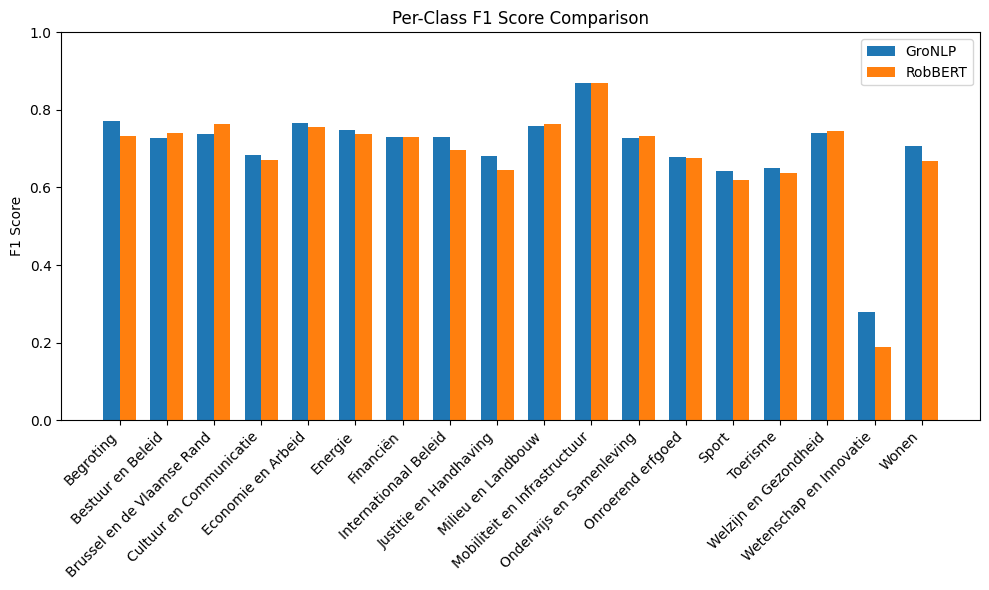

In [8]:
# Bar positions
x = np.arange(len(unique_themes))
width = 0.35

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, f1_gronlp, width, label='GroNLP')
plt.bar(x + width/2, f1_robbert, width, label='RobBERT')

# Add labels and title
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Score Comparison')
plt.xticks(x, unique_themes, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()

plt.show()